### Importing Modules

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

%matplotlib inline
font = {'family': 'normal', 'weight': 'normal','size': 16}
plt.rc('font', **font)
import seaborn
seaborn.set_style('darkgrid')

from applications.power_forecasting import *

### Running Models

building_1:


building_1 without occ
R2:  0.9187081196114875
Adj R2:  0.9186551262083659
RMSE:  24.510316018121397
MAE:  22.444838917574586
building_1 with occ
R2:  0.9230231070752398
Adj R2:  0.9229729265713775
RMSE:  27.6268233128726
MAE:  25.17718820091396
....
building_2:


building_2 without occ
R2:  0.6972380126594304
Adj R2:  0.6970406450014509
RMSE:  34.01975734737737
MAE:  25.033702627843468
building_2 with occ
R2:  0.7383988182429068
Adj R2:  0.738228282922335
RMSE:  36.82647920826331
MAE:  26.005944562196586
....
building_3:


building_3 without occ
R2:  0.4226634222701753
Adj R2:  0.42228706205001243
RMSE:  9.439316742156006
MAE:  7.810838161551015
building_3 with occ
R2:  0.4344672847593672
Adj R2:  0.43409861936481653
RMSE:  9.65262598385773
MAE:  7.992517052455813
....
building_4:


building_4 without occ
R2:  0.4978885908690957
Adj R2:  0.49756126922037935
RMSE:  3.6206087365525836
MAE:  3.0616101923589234
building_4 with occ
R2:  0.7160352857296316
Adj R2:  0.715850171

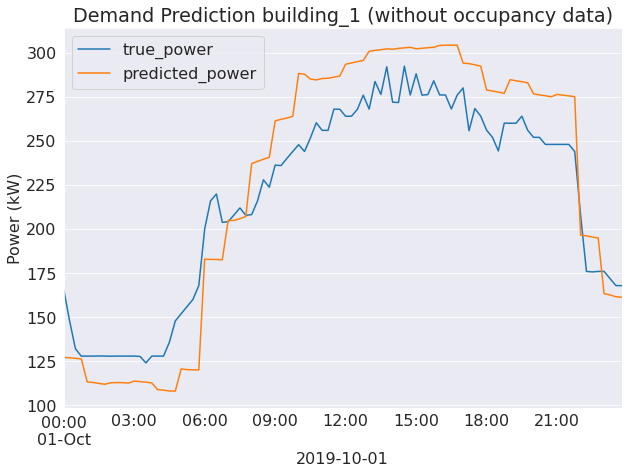

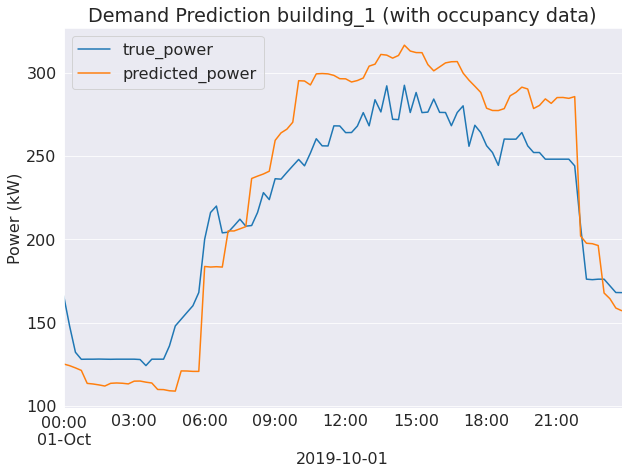

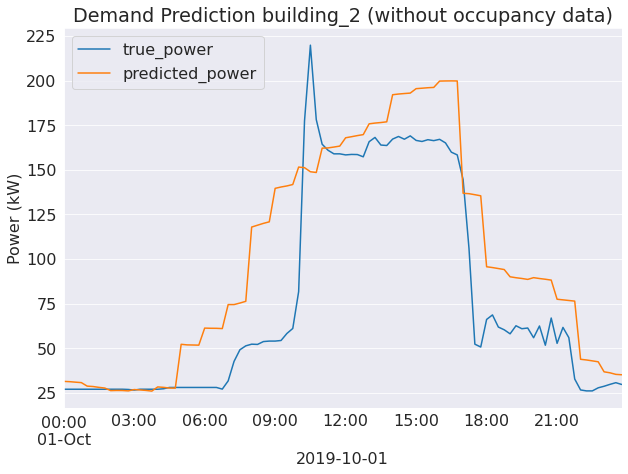

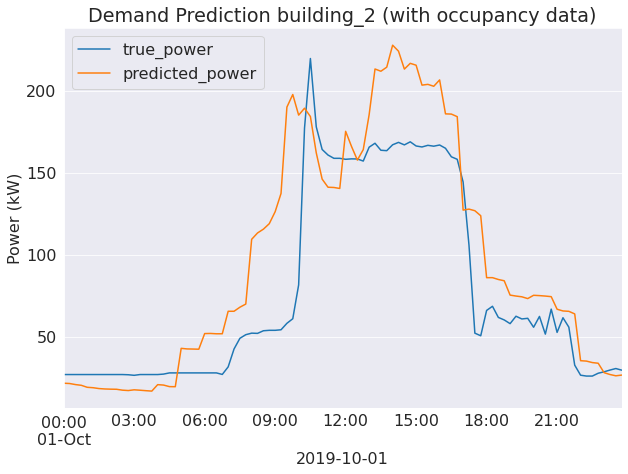

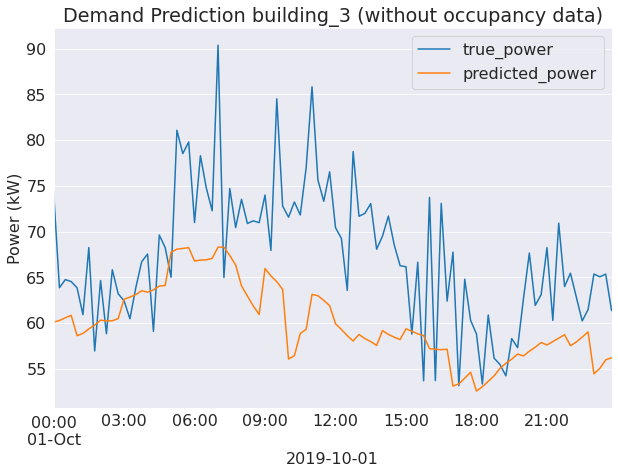

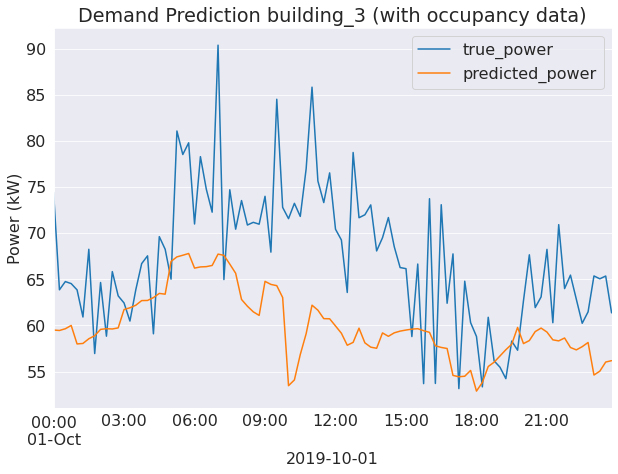

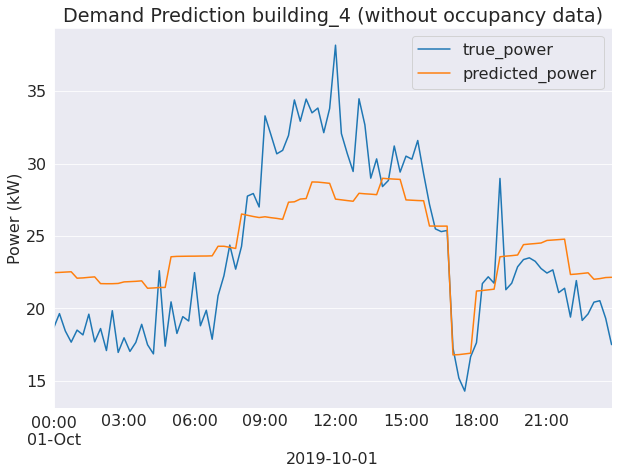

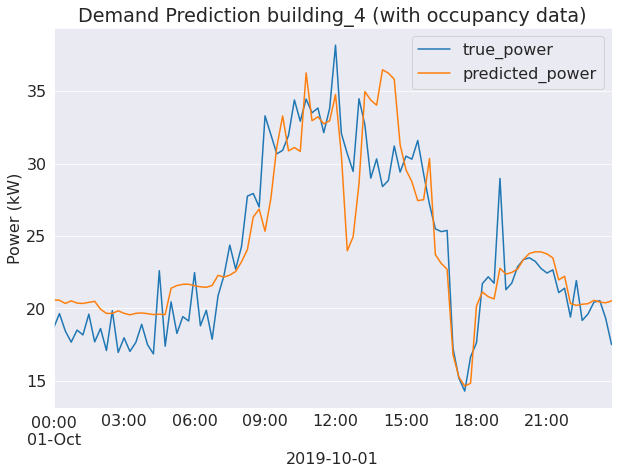

In [5]:
# Establishing Dates of Interest

st_training_period = '2019-09-15' #Start Date
et_training_period = '2019-09-30' #End Date

st_testing_period = '2019-10-01' #Start Test Date


#COUNT Retrieved Wi-fi Occupancy Data
occupancy_file = 'campus2_builing_device_count.csv'

# Externally Retrieved Tempurature Data during start and end dates in Claremont California
temp_file = 'Tempurature.csv'

# Iterating over building list
occupancy_bldg = ['building_1', 'building_2', 'building_3', 'building_4']

for bldg in occupancy_bldg:
    
    power_file = 'Power/'+ bldg + '.csv'
    
    # Occupancy Data
    df_occ = pd.read_csv(occupancy_file, index_col=[0], parse_dates=True)
    df_occupancy = pd.DataFrame(df_occ[bldg])
    df_occupancy.columns = ['Occupancy']

    # Power Data
    df_power = pd.read_csv(power_file, index_col=[0], parse_dates=True)
    df_power = df_power.set_index(df_power.index.astype(dtype='<M8[ns]'))
    
    # Weather Data
    df_weather = pd.read_csv(temp_file, index_col=[0], parse_dates=True)
    df_weather.columns = ['Temp (F)']
    
    # Resampling data every 15 min
    df_occupancy_resampled = df_occupancy.resample('15min').mean()
    df_weather_resampled = df_weather.resample('15min').mean()
    df_power_resampled = df_power.resample('15min').mean()

    # Merging the seperate dataframes
    df = df_occupancy_resampled.join(df_weather_resampled, how='outer').join(df_power_resampled, how='outer')
    
    # Ensuring proper/unified timezone
    df.index = df.index.tz_localize('UTC').tz_convert('US/Pacific')
    df = df[st_training_period:st_testing_period]
    
    # Renaming columns
    df.columns = ['occupancy', 'temp', 'power']
    
    # Removing null values
    df = df.dropna(how='any')
    
    # Adding addtional training data as time features, tool found in applications/power_forecasting
    df_processed = add_time_features(df, tod=True, dow=True)
    
    print(bldg +':')
    print('\n')
    
    # Model WITHOUT occupancy device count data
    print(bldg +' without occ')
    # Train Model
    model = train_model(df_processed, st_training_period, et_training_period, with_occ_data=False)
    # Testing Model
    project_df = make_predictions(model, df_processed, st_testing_period, with_occ_data=False)
    # Plotting Output
    plot_data(project_df, st_testing_period, bldg, with_occ_data=False)
    
    # Model WITH occupancy device count data
    print(bldg +' with occ')
    # Train Model
    model = train_model(df_processed, st_training_period, et_training_period, with_occ_data=True)
    # Testing Model
    project_df = make_predictions(model, df_processed, st_testing_period, with_occ_data=True)
    # Plotting Output
    plot_data(project_df, st_testing_period, bldg, with_occ_data=True)
    print('....')
